# Dimensionality reduction

In [333]:
!date

Mon  8 Mar 00:45:00 CET 2021


## Model evaluation
When assessing the model performance, we are interested in two things:
- **prediction** - how accurate our model is when applied to the new data
- **interpretability** - what can it tell us about the relationship between features and predictions, i.e. can we
identify important features


A general rule in machine learning is *'the more the merrier'*. Even the simplest models will generally perform better
when trained on bigger data sets, and with more measured features, one expects to be able to explain more of the
variance in the data. However, working with high dimensional data sometimes can be problematic.

Naturally, the data with fewer dimensions are easier to understand, visualize and interpret. Having a lot of dimensions
can mean that your data points are far away from virtually every other point, which makes the distances between the
data points uninformative - this is often referred to as **the curse of dimensionality**.

To deal with this, before fitting our model we need to perform some sort of dimensionality reduction.

The first possible solution is to look for the effective dimensionality of your data. In data sets where some features
are irrelevant, the effective dimensionality might be much smaller than the actual number of the features. In this case,
 we can use one of the feature selection algorithms to identify only the informative features.

Another situation would be to try to project your original features into a lower dimensional space - ths is what
dimensionality reduction (in strict sense) does.


## Feature selection

We would typically try to do feature selection when working with datasets that have many more features than observations.
For example, *n* patient samples and for each we have *p* measured characteristics, e.g. genes expression, and *p>>n*.
Why is this problematic, and why our models generally won't perform well with this kind of data? This is because,
essentially, there is not enough observations to cover all the possible combinations of features.

What to do in this case? Several most commonly used feature selection methods are:
- lasso
- ridge
- elastic net

### Case scenario 1
We will work with the [Human lung carcinomas microarray dataset](https://doi.org/10.1073/pnas.191502998) from
Bhattacharjee et al.  The goal of this exercise will be to show differences between the three feature selection methods
we explained, and to compare the results of each to the paper results (they select variable genes using a standard
deviation threshold of 50 expression units).


In [334]:
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")

Load the data.

In [335]:
data = pd.read_csv("./data/DatasetA_12600gene.csv", header=0)
data.head()
print(data.shape)
data.columns

(12600, 204)


Index(['probe set', 'AD-043T2-A7-1', 'AD-111T2-A8-1', 'AD-114T1-A9-1 *',
       'AD-115T1-A12-1 *', 'AD-118t1-A13-1', 'AD-119t3-A195-8',
       'AD-120t1-A226-8 *', 'AD-122t3-A197-8', 'AD-123T1-A25-1 *',
       ...
       'COID-COID14t1-A351-6', 'COID-COID16t1-A352-6', 'COID-COID18t1-A353-6',
       'COID-COID3t1-A340-6', 'COID-COID4t1-A341-6', 'COID-COID5t1-A342-6',
       'COID-COID6t1-A343-6', 'COID-COID7t1-A344-6', 'COID-COID8t1-A345-6',
       'COID-COID9t1-A346-6'],
      dtype='object', length=204)

We see there is one categorical variable ('probe set', containing probe i.e. gene names) and 203 numerical ones (samples).
We can summarize numeric columns in the data:

In [336]:
data.describe()


,AD-043T2-A7-1,AD-111T2-A8-1,AD-114T1-A9-1 *,AD-115T1-A12-1 *,AD-118t1-A13-1,AD-119t3-A195-8,AD-120t1-A226-8 *,AD-122t3-A197-8,AD-123T1-A25-1 *,AD-127T1-A14-1,...,COID-COID14t1-A351-6,COID-COID16t1-A352-6,COID-COID18t1-A353-6,COID-COID3t1-A340-6,COID-COID4t1-A341-6,COID-COID5t1-A342-6,COID-COID6t1-A343-6,COID-COID7t1-A344-6,COID-COID8t1-A345-6,COID-COID9t1-A346-6
count,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,...,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000
mean,100.239417,100.899244,91.333506,104.118275,93.203437,93.431129,105.971492,106.203029,95.834106,109.298414,...,121.672475,122.578717,114.799799,121.250127,110.563802,140.542330,100.358783,107.931560,123.265077,109.563598
std,316.449063,338.082066,334.014628,338.423800,339.088615,343.338231,339.469545,339.694939,338.375711,343.273469,...,295.392617,328.506923,339.944349,331.701264,326.656284,294.820844,334.361438,304.089469,326.938184,329.891901
min,-745.160000,-671.920000,-534.135000,-1005.060000,-656.200000,-603.340000,-682.200000,-792.340000,-564.180000,-610.640000,...,-588.680000,-898.380000,-871.820000,-876.930000,-773.500000,-1057.980000,-877.230000,-845.550000,-795.820000,-757.850000
25%,2.440000,11.240000,0.748750,7.915000,-1.980000,-6.040000,3.542500,3.610000,0.080000,11.810000,...,30.690000,13.330000,-2.360000,13.710000,1.680000,49.010000,-9.670000,15.630000,27.360000,-3.920000
50%,27.540000,30.360000,19.705000,30.580000,18.780000,16.190000,29.160000,28.780000,20.595000,35.320000,...,54.450000,42.200000,29.320000,41.330000,29.070000,71.050000,16.170000,38.160000,53.150000,25.710000
75%,92.400000,79.200000,69.256250,88.703750,71.920000,74.700000,94.347500,94.330000,75.585000,92.920000,...,114.670000,115.700000,111.610000,112.000000,102.980000,133.110000,87.310000,98.850000,113.690000,106.202500
max,7322.580000,7077.040000,8056.020000,7132.050000,7254.320000,6935.870000,6715.070000,7147.730000,6935.240000,7202.390000,...,8751.660000,7355.160000,8011.270000,8129.800000,7917.870000,8726.120000,8064.240000,7555.490000,8274.780000,8073.710000


For downstream work, we need to transform the data to have samples as rows and genes (probes) as columns.

In [337]:
# input matrix with features as columns
dt = data.transpose()
cols = dt.iloc[0]
dt = dt.iloc[3:,]
dt.columns = cols
dt = dt.apply(pd.to_numeric, errors='coerce')
dt.head()

probe set,AFFX-MurIL2_at,AFFX-MurIL10_at,AFFX-MurIL4_at,AFFX-MurFAS_at,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,...,100_g_at,101_at,102_at,103_at,104_at,105_at,106_at,107_at,108_g_at,109_at
AD-114T1-A9-1 *,-2.175,-2.21,-0.060,6.320,-1.775,-16.53,-3.610,16.410,-17.970,-57.020,...,67.44,14.610,10.875,10.615,35.140,1.745,29.710,10.465,-42.63,73.735
AD-115T1-A12-1 *,-1.540,21.75,5.835,23.815,-24.785,-12.89,-4.485,19.500,-21.445,-47.205,...,133.94,9.615,27.355,30.860,48.710,10.355,40.845,54.615,-71.38,65.435
AD-118t1-A13-1,-9.070,3.08,-1.980,17.260,-10.090,-15.15,-18.190,13.210,-13.130,-39.470,...,99.23,-14.140,23.340,6.120,33.460,-10.090,40.550,16.250,-48.59,39.540
AD-119t3-A195-8,-16.580,-20.09,-8.390,4.490,-18.920,-20.09,-8.390,16.190,-38.820,-56.380,...,127.33,13.850,8.000,75.870,37.260,-11.900,24.390,54.810,-47.02,59.490
AD-120t1-A226-8 *,-15.895,10.88,1.610,23.845,-21.980,-29.00,-3.865,23.635,-19.010,-65.195,...,189.52,13.755,25.300,12.680,53.485,6.920,48.120,42.560,-81.71,39.965


Outlier samples can influence PCA. We identify potential outliers as those with mean z value higher than 1.

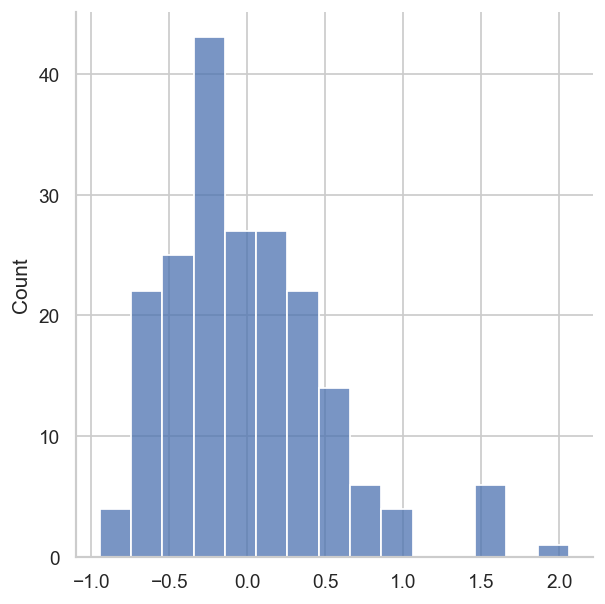

In [338]:
from scipy.stats import zscore

dtzscore = dt.apply(zscore).mean(axis=1)
sns.displot(dtzscore)

We remove the outliers.

In [339]:
outliers = dtzscore[abs(dtzscore)>1.5].index
print(outliers)
dt = dt.drop(outliers, axis=0)
dt.shape

Index(['AD-338t1a-A121-3 *', 'AD-351t1-A127-3', 'SMCL-SMCL8t1-A356-6',
       'COID-2260-A304-5', 'COID-4518-A305-5', 'COID-9794-A300-5',
       'COID-COID5t1-A342-6'],
      dtype='object')


(194, 12600)

In [340]:
dt = np.clip(dt, -200, 200)


Classes in the data are:


* normal lung (NL)
* neuroendocrine tumors
  * small-cell lung cancer (SMCL)
  * pulmonary carcinoids (COID)
* squamous cell lung carcinoma (SQ)
* adenocarcinomas (AD)

We extract tumor class indicators from sample names.

In [341]:
samples = pd.Series(list(dt.index)[0:])
classes = samples.str.extract(r'(AD|NL|SMCL|SQ|COID)')
classes.value_counts()

AD      135
SQ       21
NL       17
COID     16
SMCL      5
dtype: int64

Now we can summarize the expression of each gene by tumor class.

In [342]:
dt['Class'] = classes.values
dt.groupby(['Class']).mean()

probe set,AFFX-MurIL2_at,AFFX-MurIL10_at,AFFX-MurIL4_at,AFFX-MurFAS_at,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,...,100_g_at,101_at,102_at,103_at,104_at,105_at,106_at,107_at,108_g_at,109_at
Class,,,,,,,,,,,,,,,,,,,,,
AD,-9.787228,3.650728,0.046901,18.282087,-13.966179,-19.503359,-6.016191,23.879061,-22.428679,-53.303679,...,131.703622,6.624586,18.891345,14.928549,43.322530,1.714315,35.829105,29.154241,-59.838010,69.469624
COID,3.903125,13.878125,8.435000,32.513750,-11.999375,-15.666875,4.952500,24.795625,-24.431875,-51.871875,...,187.486875,0.435625,21.081875,36.623750,58.121875,10.511875,24.028750,36.587500,-31.886875,93.003125
NL,-18.127647,-7.629412,-10.631176,13.154706,-32.394706,-40.350000,-8.334118,14.532353,-31.537647,-57.608235,...,105.974118,-7.731765,2.073529,-4.917059,34.986471,-8.917059,31.642353,34.871765,-86.042941,55.991176
SMCL,8.104000,13.942000,6.450000,24.626000,-24.582000,-32.050000,-11.842000,28.720000,-30.864000,-66.436000,...,134.646000,-3.078000,30.372000,18.754000,70.828000,7.992000,53.228000,24.454000,-51.656000,70.496000
SQ,-18.898571,-9.160000,-14.440000,4.210476,-28.203333,-37.127619,-16.997143,-0.824286,-36.459048,-59.486667,...,135.947143,3.051905,4.211429,-4.859524,23.317619,-12.938095,39.040476,24.648571,-89.865714,68.809048


Finally, we extract only the numeric gene values for training the models.

In [343]:
# get numeric columns from data
tmat = dt.drop('Class', axis=1)

## Dimensionality reduction

We might be working with a dataset that have both large number of observations and features. A typical example would be
single cell experiments, with tens of thousands of cells and tens of thousands of features (gene expression, methylation,
 or ChIP signal etc.) measured in each cell.

What options are there?  
- PCA
- tSNE
- UMAP

PCA is a linear transformation method that identifies the directions (principal components) that maximize the variance
of the data.

For a simplified step-by-step explanation of maths behind PCA, check out [StatQuest video](https://youtu.be/FgakZw6K1QQ).

PCA is using a method called singular value decomposition (SVD) to transform our original data matrix. Essentially, it
computes independent (i.e. perpendicular) singular vectors (eigenvectors) $$\nu$$ along which the data are spread.
Each eigenvector has the corresponding singular value (eigenvalue) $$\lambda$$, which is the sum of squared distances
between the data points projected on the eigenvector and the center of the data.

$$ \sum_{}{}{\nu}=\lambda\nu $$

Eigenvectors associated with eigenvalues that are much higher than others contain more information about our data
distribution. Vice versa, eigenvalues that are close to 0 are less informative, and we usually drop those to reduce
the dimensionality of our data.

To generate a representation of the data in the lower-dimensional space, PCA collects eigenvectors with the highest
eigenvalues in an eigenvector matrix $$ W $$ and transform the data into the new subspace by multiplication.

$$ y=W^{T}\times x $$

We first need to standardize features by removing the mean and scaling to unit variance.
This is necessary because a feature that has orders of magnitude larger variance than others might dominate the model
and make it take other features correctly into account.

The standard score of a feature x is calculated as:

    z = (x - u) / s

where u is the mean and s is the standard deviation.

In [344]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(tmat)
print(scaler.mean_)
print(scaler.scale_)
X = scaler.transform(tmat)

#same can be done with a one-liner:
#X = StandardScaler().fit_transform(tmat)

#scaled data has mean 0 and var 1
X.mean(axis=0)
X.std(axis=0)

[ -9.91415361   2.38426978  -1.60014609 ...  29.65944587 -62.86861495
  70.18437732]
[17.60989243 17.99073575 16.04323055 ... 42.59516681 42.0765482
 28.65533722]


array([1., 1., 1., ..., 1., 1., 1.])

PCA

/home/anamaria/anaconda3/envs/ml_cnag-crg_course/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

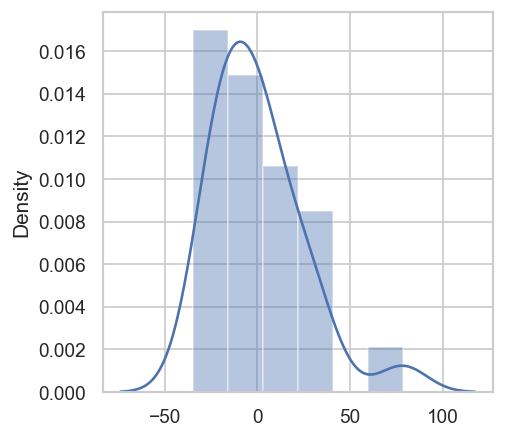

In [345]:
sns.distplot(pca_reduced_data[:,4])
#sns.distplot(X.max(axis=1))

In [346]:
from sklearn.decomposition import PCA

# build PCA model 
pca = PCA(n_components=6)

# fit and transform the data to the model
pca_reduced_data = pca.fit_transform(X)

# inspect the shape
pca_reduced_data.shape

(194, 6)

Plot the data projected on the first two principal components

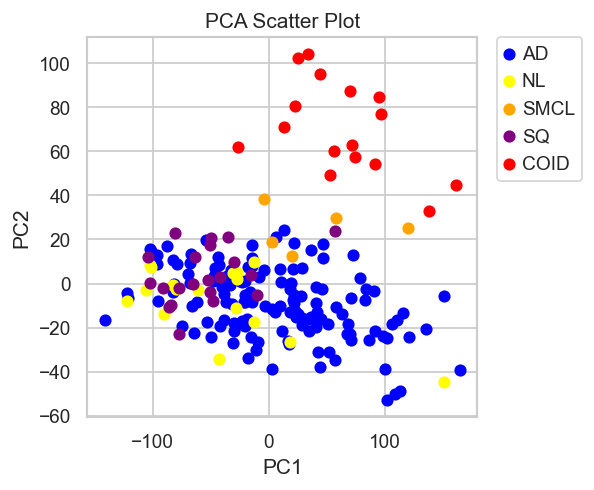

In [347]:
colors = ['blue', 'yellow', 'orange', 'purple', 'red']
cl = ['AD', 'NL', 'SMCL', 'SQ', 'COID']
for i in range(len(colors)):
    ind = classes == cl[i]
    x = pca_reduced_data[:,0][ind.values[:,0]]
    y = pca_reduced_data[:,1][ind.values[:,0]]
    plt.scatter(x, y, c=colors[i])
plt.legend(cl, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA Scatter Plot")
plt.show()

We see that all samples cannot be separated using the two first principal components, which account for less than 40%
of the variance in the data.

[0.34537373 0.05960062 0.03870312 0.03115119 0.02138505 0.0154431 ]


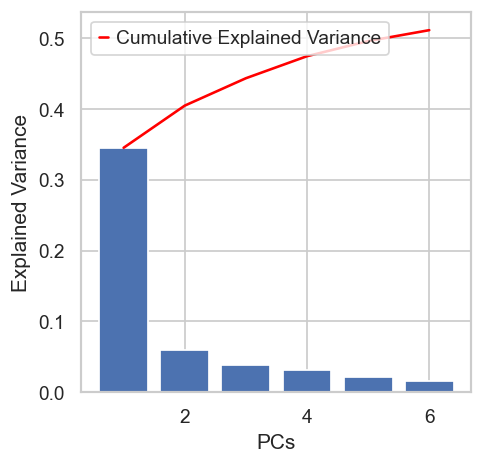

In [348]:
print(pca.explained_variance_ratio_)
plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
plt.ylabel('Explained Variance')
plt.xlabel('PCs')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

Squamous cell lung carcinoma (SQ) and adenocarcinoma (AD) samples are largely overlapping with the normal lung samples,
whereas the two neuroendocrine tumors are separating better, so we only select the former and repeat the same exercise.

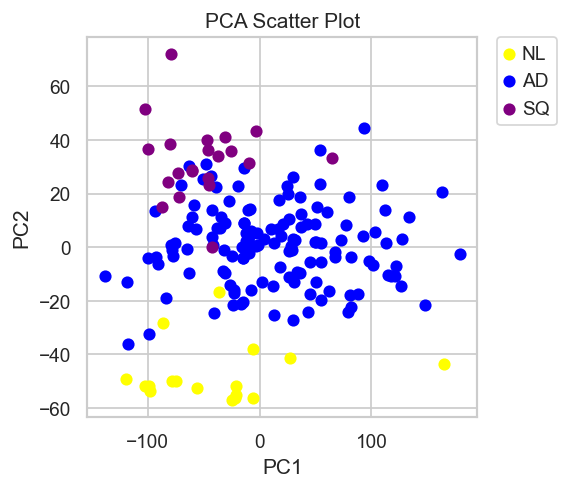

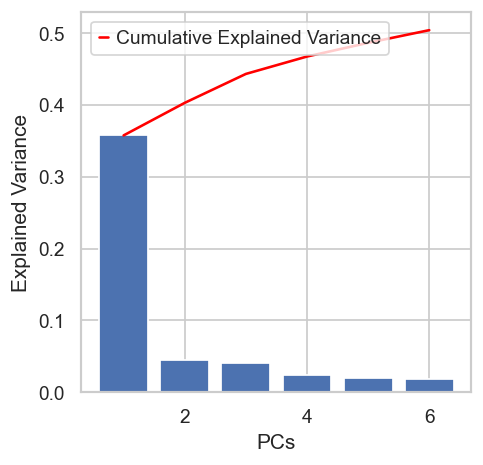

In [349]:
selected = classes.isin(['NL','SQ','AD'])
tmatfilt = tmat.filter(regex=r'(NL|SQ|AD)', axis=0)

# scale
scaler = StandardScaler()
X = StandardScaler().fit_transform(tmatfilt)

# classes from sample names
samples = pd.Series(list(tmatfilt.index))
classes = samples.str.extract(r'(NL|SQ|AD)')
classes.value_counts()

# build PCA model 
pca = PCA(n_components=6)

# fit and transform the data to the model
pca_reduced_data = pca.fit_transform(X)

# plot
colors = ['yellow', 'blue', 'purple']
cl = ['NL', 'AD', 'SQ']
for i in range(len(colors)):
    ind = classes == cl[i]
    x = pca_reduced_data[:,0][ind.values[:,0]]
    y = pca_reduced_data[:,1][ind.values[:,0]]
    plt.scatter(x, y, c=colors[i])
plt.legend(cl, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA Scatter Plot")
plt.show()

# variance
plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
plt.ylabel('Explained Variance')
plt.xlabel('PCs')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')
plt.show()

Now the two tumor types are better separated from the normal sample, even though they are still overlapping.
Accordingly, we see that the PC2, along which they are separated, explains a very small proportion of variance between
these samples.

In [350]:
pca.explained_variance_ratio_

array([0.35760462, 0.04536709, 0.04029272, 0.02424542, 0.01909528,
       0.0176367 ])

We do the same for the two neuroendocrine tumors.

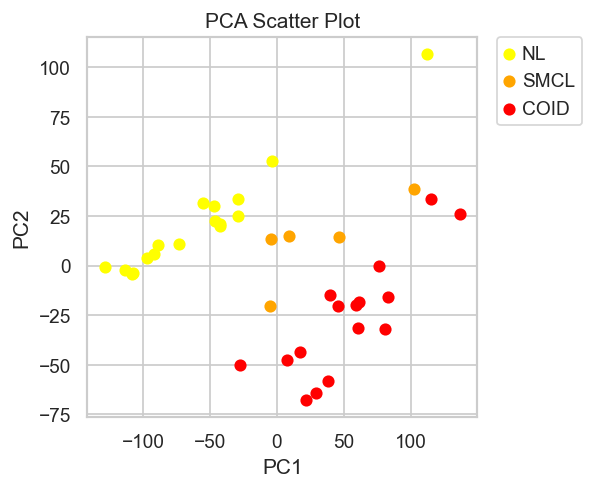

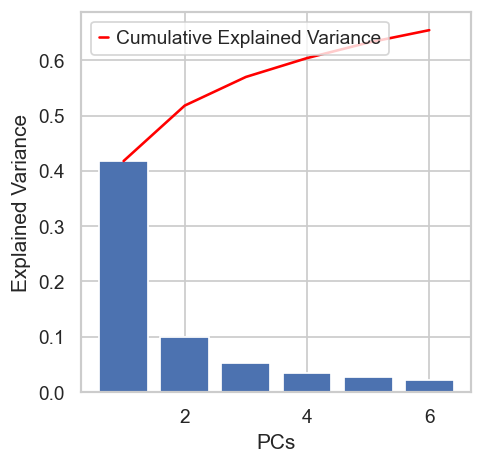

In [351]:
selected = classes.isin(['NL','SMCL','COID'])
tmatfilt = tmat.filter(regex=r'(NL|SMCL|COID)', axis=0)

# scale
scaler = StandardScaler()
X = StandardScaler().fit_transform(tmatfilt)

# classes from sample names
samples = pd.Series(list(tmatfilt.index))
classes = samples.str.extract(r'(NL|SMCL|COID)')
classes.value_counts()

# build PCA model 
pca = PCA(n_components=6)

# fit and transform the data to the model
pca_reduced_data = pca.fit_transform(X)

# plot
colors = ['yellow', 'orange', 'red']
cl = ['NL', 'SMCL', 'COID']
for i in range(len(colors)):
    ind = classes == cl[i]
    x = pca_reduced_data[:,0][ind.values[:,0]]
    y = pca_reduced_data[:,1][ind.values[:,0]]
    plt.scatter(x, y, c=colors[i])
plt.legend(cl, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA Scatter Plot")
plt.show()

# variance
plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
plt.ylabel('Explained Variance')
plt.xlabel('PCs')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')
plt.show()

In this case the separation is better.

In [352]:
pca.explained_variance_ratio_

array([0.41783969, 0.10022737, 0.05175384, 0.03408126, 0.02801462,
       0.02252216])

An important point to make here is that in PCA we are trying to find the axes with maximum variances where the data is
most spread. This is not a classification algorithm, and labeling the points is completely independent of the model
building and its performance. A related linear transformation method that maximizes the variance in the data, and
additionally finds the directions that maximize the separation between different classes is called Multiple Discriminant
Analysis (MDA).

When it comes to interpretability of PCA models, we already mentioned that the PCs represent directions of variance in
the data. We can also identify the key variables (here, genes) that contribute to the explanation of most variance in
the data set. The importance of each feature is reflected by the magnitude of the corresponding values in the
eigenvectors, where higher magnitude means higher contribution of that feature to the PC.

Let’s find the most important features.

[ 4459  5065  3052  1943  1668  3808 10032  3247  8335  3430  9152  8832
  3386 10238 10388  6990  7571  6008  3323   669]
[0.01349235 0.01350315 0.01351353 0.01352708 0.01352967 0.01354809
 0.01355403 0.01355588 0.01355606 0.01355986 0.01356039 0.01356472
 0.01356661 0.01357817 0.01358855 0.01359248 0.01360703 0.01363056
 0.0136325  0.01372881]
['41683_i_at', '33765_at', '37522_r_at', '33538_at', '32308_r_at', '39954_r_at', '40943_at', '38195_at', '35772_at', '38857_r_at', '38387_at', '37349_r_at', '38574_at', '41509_at', '41843_r_at', '40121_at', '32258_r_at', '37223_at', '38511_at', '32386_at']


Text(0, 0.5, 'Gene')

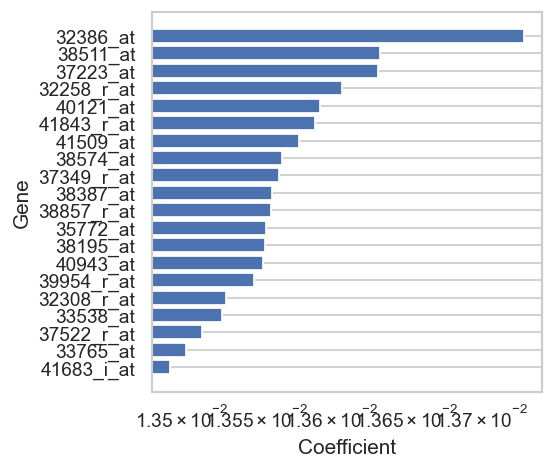

In [353]:
# get top genes to plot
ids = np.argsort(abs(pca.components_)[0,:],axis=0)[-20:]
print(ids)
coeff = abs(np.transpose(pca.components_)[ids,:][:,0])
print(coeff)
labels = np.asarray(tmatfilt.columns)[ids].tolist()
print(labels)

plt.barh(labels,coeff)
plt.xscale('log',base=10)
plt.xlabel('Coefficient')
plt.ylabel('Gene')

In [354]:
# get gene names
geneannot = pd.read_table("data/Annotation_genes.tsv")
